In [1]:
import torch
import os, sys
import numpy as np
module_rootdir = '.'
dataset_rootdir = '../'
label_rootdir = module_rootdir
weight_rootdir = module_rootdir
sys.path.append(module_rootdir)

from modules.first_stage.inference import inference
from modules.first_stage.set_parameters_for_inference import set_param_for_inference
from modules.plot.viz_annotation import vizualize_bbox_resized, vizualize_bbox_resized_veh_ped

In [2]:
weights_file = 'model_weights/1705990924432/anchor_free_detector.pt'

param_dict = set_param_for_inference(
    dataset_type = 'kitti',
    module_rootdir = module_rootdir,
    dataset_rootdir = dataset_rootdir,
    label_rootdir = label_rootdir,
    batch_size = 1,
    trained_weights_file = os.path.join(weight_rootdir, weights_file),
    shuffle_dataset = True)

device = param_dict['device']
dataset_param = param_dict['dataset_param']
dataset_train = param_dict['dataset_train']
dataset_val = param_dict['dataset_val'] 
detector = param_dict['detector']

deltas_mean = torch.tensor(dataset_param.deltas_mean, dtype=torch.float32, device=device)
deltas_std = torch.tensor(dataset_param.deltas_std, dtype=torch.float32, device=device)
grid_coord = dataset_param.grid_coord.to(device)

GPU is available. Good to go!
printing model config parameters
----------------------------------------------------------------------------------------------------
backbone                        : efficientnet_b4
num_backbone_nodes              : 4
num_extra_blocks                : 1
num_levels                      : 5
extra_blocks_feat_dim           : 512
num_fpn_blocks                  : 2
fpn_feat_dim                    : 128
prediction head stem_channels   : [128, 128, 128, 128]
activation                      : swish
image dimension BDD (H, W, D)   : (360, 640, 3)
image dimension KITTI (H, W, D) : (263, 873, 3)
num_classes                     : 2
DEVICE                          : cuda
****************************************************************************************************
 
Loading JSON file .. please wait
Sequence: 0000
Sequence: 0001
Sequence: 0002
Sequence: 0003
Sequence: 0004
Sequence: 0005
Sequence: 0006
Sequence: 0008
Sequence: 0009
Sequence: 0011
Sequence: 0012

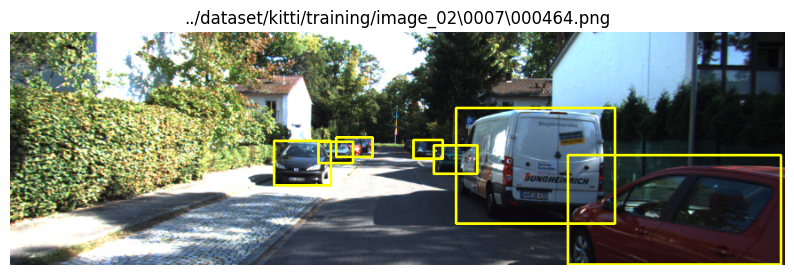

prediction scores in ascending order:
[0.8249287  0.83660877 0.9200921  0.9216411  0.9482105  0.9506751
 0.9541035 ]
classification scores in ascending order:
[0.9996074  0.9998313  0.9999174  0.99992394 0.9999268  0.99993134
 0.99996316]


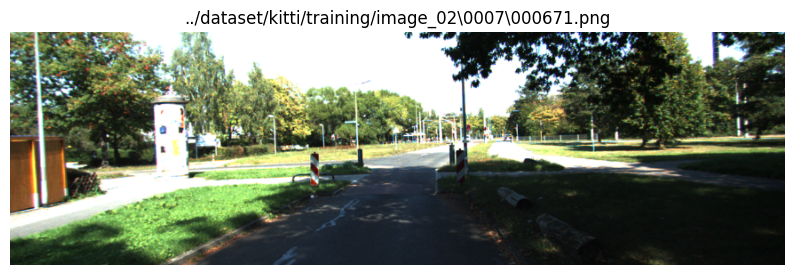

prediction scores in ascending order:
[]
classification scores in ascending order:
[]


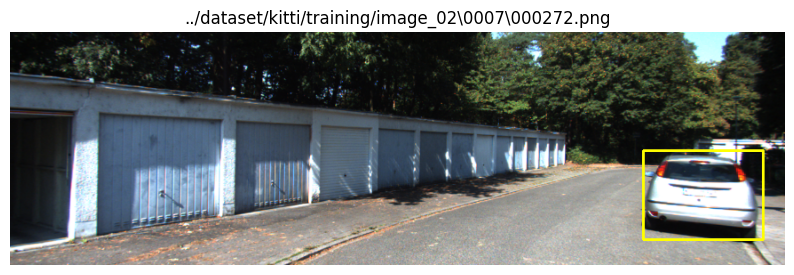

prediction scores in ascending order:
[0.9702661]
classification scores in ascending order:
[0.9999571]


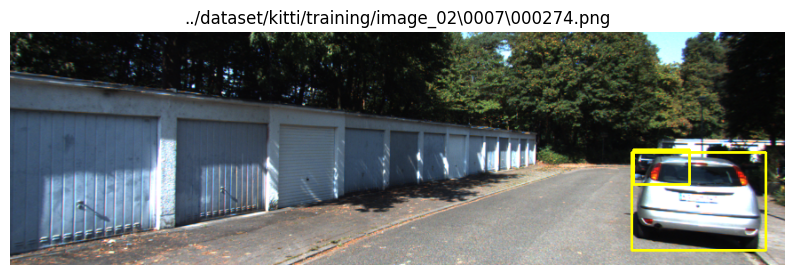

prediction scores in ascending order:
[0.8143381 0.9696449]
classification scores in ascending order:
[0.99995613 0.9999794 ]


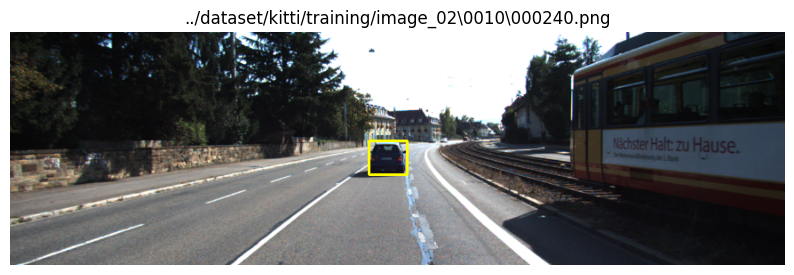

prediction scores in ascending order:
[0.95901]
classification scores in ascending order:
[0.99983263]


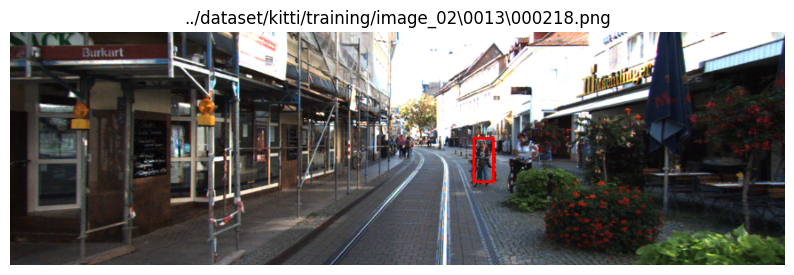

prediction scores in ascending order:
[0.70746446]
classification scores in ascending order:
[0.99484175]


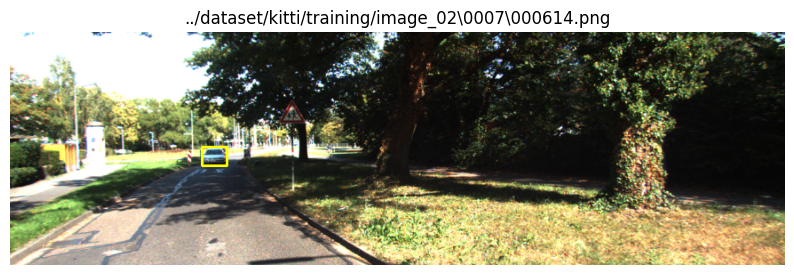

prediction scores in ascending order:
[0.9344145]
classification scores in ascending order:
[0.9999577]


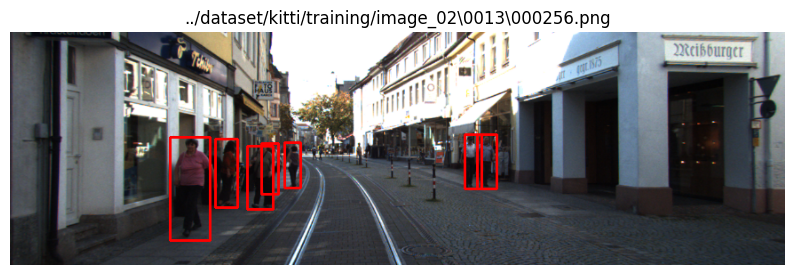

prediction scores in ascending order:
[0.65127736 0.8501022  0.88998103 0.897475   0.9072019  0.9108988
 0.95032895]
classification scores in ascending order:
[0.9981123  0.9995616  0.9997961  0.9998018  0.9999907  0.99999535
 0.99999917]


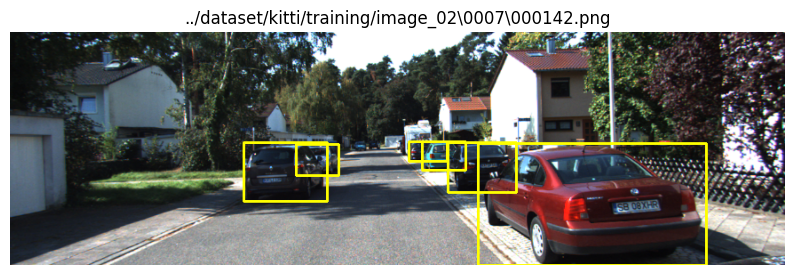

prediction scores in ascending order:
[0.80027455 0.92397976 0.94881415 0.95113766 0.9609049  0.96409345]
classification scores in ascending order:
[0.999843   0.9998764  0.9999187  0.99994576 0.9999559  0.9999722 ]


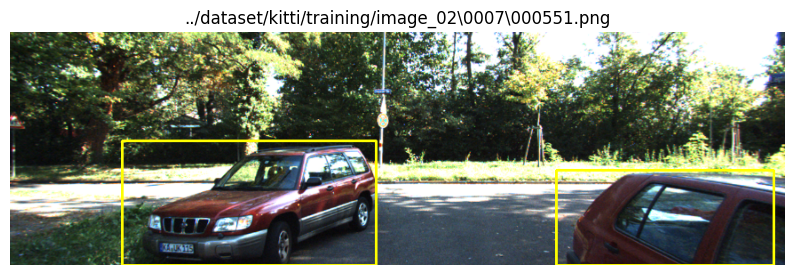

prediction scores in ascending order:
[0.9401994 0.9533275]
classification scores in ascending order:
[0.99978095 0.9999006 ]


In [3]:
# dataset = dataset_train
dataset = dataset_val
iter_start_offset = 0
max_iters = iter_start_offset + 10

nms_thresh = 0.35
score_threshold = torch.tensor([0.7, 0.6], dtype=torch.float32).to(device)

for iter in range(iter_start_offset, max_iters):

    img, labels = dataset.__getitem__(iter)
    img_path = labels['img_path']
    img = img.unsqueeze(0).to(device)
    bboxes = [labels['bbox'].to(device)]
    clslabels = [labels['obj_class_label'].to(device)]

    pred = inference(
        detector, img, grid_coord, 
        deltas_mean, deltas_std,
        score_threshold, nms_thresh)
    
    pred_score = pred['pred_score'].cpu().numpy()
    pred_class = pred['pred_class'].cpu().numpy()
    pred_box = pred['pred_box'].cpu().numpy()
    cls_prob = pred['cls_prob'].cpu().numpy()

    vizualize_bbox_resized_veh_ped(img_path, pred_box, pred_class,
                                   dataset_param.IMG_RESIZED_W, dataset_param.IMG_RESIZED_H, 
                                   thickness = 2, figsize=(10,8))

    print('prediction scores in ascending order:')
    print(np.sort(pred_score))
    print('classification scores in ascending order:')
    print(np.sort(cls_prob))
    print('=' * 100)